In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
import xgboost as xgb
import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [2]:
raw_df = pd.read_csv('/Users/jiayiluo/Desktop/BA Competition/SBAnational.csv')

In [3]:
raw_df.shape

(899164, 27)

In [4]:
df = raw_df.iloc[:10000,:]
#df = new_raw_df.(100)

In [5]:
def clean_dataset(df):
    # Drop the ChgOffDate
    df = df.drop(columns=['ChgOffDate'])
    
    # drop any nans
    df = df.dropna()
    
    # Remove $ and , from amounts and convert to numeric
    money_cols = [
        'DisbursementGross',
        'BalanceGross',
        'ChgOffPrinGr',
        'GrAppv',
        'SBA_Appv',
    ]
    for col in money_cols:
        df[col] = df[col].replace({'\$': '', ',': ''}, regex=True).astype(float)
    
    # convert fiscal year and system code to int
    misc_numerical = ['ApprovalFY', 'NAICS'] 
    for col in misc_numerical:
        df[col] = df[col].astype(str).str.replace(r'[^\d]', '', regex=True).astype(int)

    # extract year and quarter from each of the dt columns
    date_cols = ["ApprovalDate", "DisbursementDate"]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], format='%d-%b-%y')  # Format is YYYY-MM-DD
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_quarter'] = df[col].dt.quarter
        df = df.drop(columns=[col])
        
    # clean categorical variables then make dummies
    binary_variables = ['NewExist', 'MIS_Status', 'RevLineCr', 'LowDoc'] 

    df = df[df['NewExist'] != 0.0]
    df['NewExist'] = df['NewExist'].astype(int)
    df = df[df['LowDoc'].isin(['Y', 'N'])]
    df = df[df['RevLineCr'].isin(['Y', 'N'])]
    
    for col in binary_variables:
        df[col] = df[col].astype('category')
        
        df_dummies = pd.get_dummies(df[binary_variables], drop_first=True)
    df = df.drop(columns=binary_variables).join(df_dummies)
    
    # Remove a column in-place
    df.drop(['Name','City', 'State', 'Bank','BankState'], axis=1, inplace=True)

    
    return df

In [6]:
df = clean_dataset(raw_df)
df.head(10)

,LoanNr_ChkDgt,Zip,NAICS,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,ApprovalDate_year,ApprovalDate_quarter,DisbursementDate_year,DisbursementDate_quarter,NewExist_2,MIS_Status_P I F,RevLineCr_Y,LowDoc_Y
0,1000014003,47711,451120,1997,84,4,0,0,1,0,60000.0,0.0,0.0,60000.0,48000.0,1997,1,1999,1,True,True,False,True
1,1000024006,46526,722410,1997,60,2,0,0,1,0,40000.0,0.0,0.0,40000.0,32000.0,1997,1,1997,2,True,True,False,True
2,1000034009,47401,621210,1997,180,7,0,0,1,0,287000.0,0.0,0.0,287000.0,215250.0,1997,1,1997,4,False,True,False,False
3,1000044001,74012,0,1997,60,2,0,0,1,0,35000.0,0.0,0.0,35000.0,28000.0,1997,1,1997,2,False,True,False,True
4,1000054004,32801,0,1997,240,14,7,7,1,0,229000.0,0.0,0.0,229000.0,229000.0,1997,1,1997,2,False,True,False,False
5,1000084002,6062,332721,1997,120,19,0,0,1,0,517000.0,0.0,0.0,517000.0,387750.0,1997,1,1997,2,False,True,False,False
6,1000093009,7083,0,1980,45,45,0,0,0,0,600000.0,0.0,208959.0,600000.0,499998.0,1980,2,1980,3,True,False,False,False
7,1000094005,34491,811118,1997,84,1,0,0,1,0,45000.0,0.0,0.0,45000.0,36000.0,1997,1,1998,2,True,True,False,True
8,1000104006,32456,721310,1997,297,2,0,0,1,0,305000.0,0.0,0.0,305000.0,228750.0,1997,1,1997,3,True,True,False,False
9,1000124001,6073,0,1997,84,3,0,0,1,0,70000.0,0.0,0.0,70000.0,56000.0,1997,1,1997,2,True,True,False,True


EDA
MISSING VALUE ANALYSIS NUMERICAL FEATURE ANALYSIS CATEGORICAL FEATURE ANALYSIS CORELATION ANALYSIS OUTLIER ANALYSIS DATA VISUALISATION

In [7]:
#MISSING VALUE ANALYSIS
# Total missing values per column
missing_percentage = df.isnull().mean() * 100
print(missing_percentage)

LoanNr_ChkDgt               0.0
Zip                         0.0
NAICS                       0.0
ApprovalFY                  0.0
Term                        0.0
NoEmp                       0.0
CreateJob                   0.0
RetainedJob                 0.0
FranchiseCode               0.0
UrbanRural                  0.0
DisbursementGross           0.0
BalanceGross                0.0
ChgOffPrinGr                0.0
GrAppv                      0.0
SBA_Appv                    0.0
ApprovalDate_year           0.0
ApprovalDate_quarter        0.0
DisbursementDate_year       0.0
DisbursementDate_quarter    0.0
NewExist_2                  0.0
MIS_Status_P I F            0.0
RevLineCr_Y                 0.0
LowDoc_Y                    0.0
dtype: float64


In [8]:
#NUMERICAL FEATURE ANALYSIS
# Variance
print("Variance:")
print(df.var())

# Skewness
print("\nSkewness:")
print(df.skew())

Variance:
LoanNr_ChkDgt               6.380649e+18
Zip                         9.636664e+08
NAICS                       6.986034e+10
ApprovalFY                  4.449023e+01
Term                        5.707519e+03
NoEmp                       5.688667e+03
CreateJob                   8.132676e+04
RetainedJob                 8.138064e+04
FranchiseCode               1.187913e+08
UrbanRural                  4.257407e-01
DisbursementGross           7.129254e+10
BalanceGross                2.767898e+06
ChgOffPrinGr                3.078157e+09
GrAppv                      6.638958e+10
SBA_Appv                    4.435728e+10
ApprovalDate_year           4.443995e+01
ApprovalDate_quarter        1.193010e+00
DisbursementDate_year       4.333225e+01
DisbursementDate_quarter    1.242018e+00
NewExist_2                  1.973763e-01
MIS_Status_P I F            1.483523e-01
RevLineCr_Y                 2.192227e-01
LowDoc_Y                    8.479188e-02
dtype: float64

Skewness:
LoanNr_ChkDgt        

In [9]:
#CATEGORICAL FEATURE ANALYSIS
# Cross tabulation between Gender and Department
cross_tab = pd.crosstab(df["NewExist_2"], df["MIS_Status_P I F"], normalize=True)
print(cross_tab)

MIS_Status_P I F     False     True 
NewExist_2                          
False             0.131478  0.597922
True              0.049700  0.220901


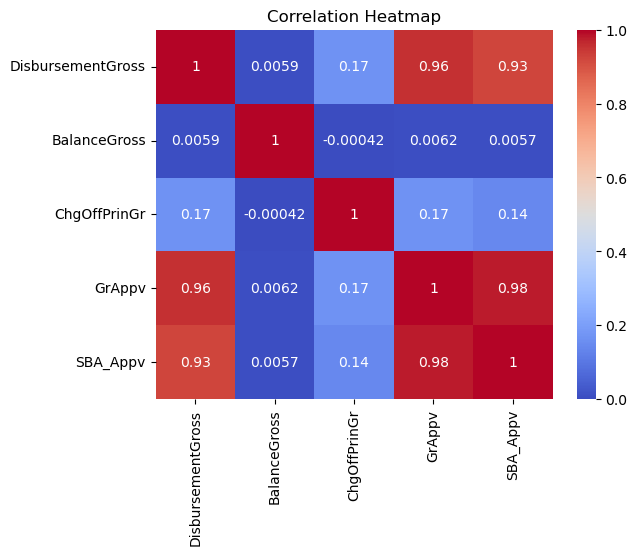

In [10]:
#CORELATION ANALYSIS
money_cols = [
        'DisbursementGross',
        'BalanceGross',
        'ChgOffPrinGr',
        'GrAppv',
        'SBA_Appv',
    ]
subset_df = df[money_cols]
sns.heatmap(subset_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

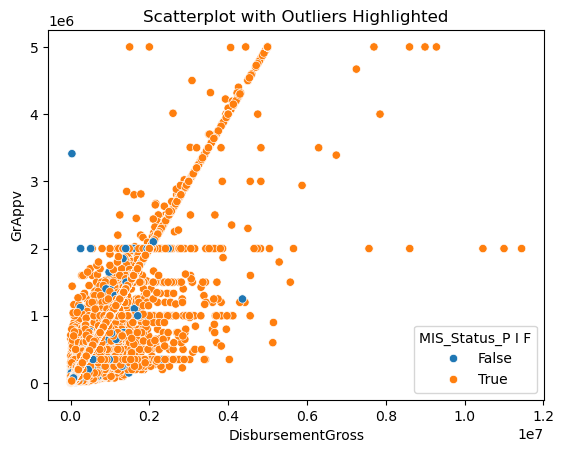

In [11]:
#OUTLIER ANALYSIS
# Scatterplot with Outliers

sns.scatterplot(x=df['DisbursementGross'], y=df['GrAppv'], hue=df['MIS_Status_P I F'])
plt.title('Scatterplot with Outliers Highlighted')
plt.show()

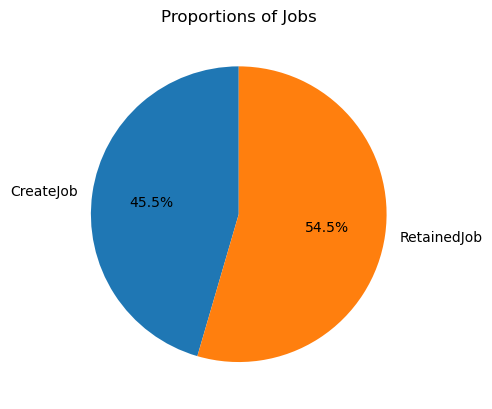

In [12]:
#DATA VISUALISATION
# Calculate totals for pie chart
totals = df[['CreateJob', 'RetainedJob']].sum()
labels = ['CreateJob', 'RetainedJob']
sizes = totals.values

# Create the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Proportions of Jobs')
plt.show()

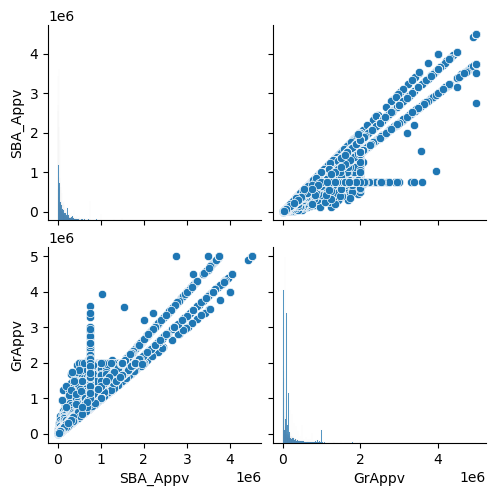

In [13]:
approval = df[['SBA_Appv', 'GrAppv']]

# Pair plot 
sns.pairplot(approval)
plt.show()

Model training

In [14]:
# knn
predictors =  ['DisbursementGross','BalanceGross','ChgOffPrinGr','GrAppv','SBA_Appv','NewExist_2','RevLineCr_Y','LowDoc_Y']
outcome = ['MIS_Status_P I F']
X = df[predictors]
y= df[outcome]

In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.2, random_state=50)
X_train.head()

,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,NewExist_2,RevLineCr_Y,LowDoc_Y
857438,15750.0,0.0,0.0,15000.0,7500.0,False,True,False
591124,24000.0,0.0,23999.0,24000.0,12000.0,False,True,False
766975,25000.0,0.0,0.0,25000.0,22500.0,True,False,True
158521,60000.0,0.0,18852.0,60000.0,48000.0,True,False,False
71067,30000.0,0.0,0.0,30000.0,24000.0,True,False,True


In [16]:
# Initialize and train KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [17]:
#xgboost
# Convert data into DMatrix format (preferred for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': 3,               # Number of classes
    'max_depth': 4,               # Max depth of trees
    'eta': 0.3,                   # Learning rate
    'eval_metric': 'mlogloss'     # Evaluation metric
}

# Train the XGBoost model
bst = xgb.train(params, dtrain, num_boost_round=50)

# Predict on the test set
preds = bst.predict(dtest)

# Evaluate the model
accuracy = accuracy_score(y_test, preds)

# Save the model
bst.save_model('xgboost_model.json')

# Load the model (optional)
loaded_model = xgb.Booster()
loaded_model.load_model('xgboost_model.json')

In [18]:
def evaluate_model(model, valid_X, valid_y, cutoff=0.25):
    """
    Evaluate a binary classification model's performance and financial outcomes
    on the validation set only.
    """
    # Predict probabilities
    if hasattr(model, "predict_proba"):
        probabilities = model.predict_proba(valid_X)[:, 1]
    elif hasattr(model, "decision_function"):
        probabilities = model.decision_function(valid_X)
    elif hasattr(model, "predict"):
        if isinstance(valid_X, pd.DataFrame):
            valid_X_dmatrix = xgb.DMatrix(data=valid_X, label=valid_y)
        else:
            valid_X_dmatrix = xgb.DMatrix(valid_X)
        probabilities = model.predict(valid_X_dmatrix)
    else:
        raise ValueError("Model type not supported for prediction.")
    
    # Ensure valid_X is a DataFrame
    if not isinstance(valid_X, pd.DataFrame):
        valid_X = pd.DataFrame(valid_X)

    # Convert probabilities to a NumPy array if needed
    if isinstance(probabilities, xgb.DMatrix):
        probabilities = probabilities.get_label()  # Extract labels from DMatrix
    elif not isinstance(probabilities, np.ndarray):
        probabilities = np.array(probabilities)  # Ensure it's a NumPy array

    # Apply cutoff for classification
    predictions = (probabilities >= cutoff).astype(int)
    
    # Display classification metrics
    specificity = confusion_matrix(valid_y, predictions)[0, 0] / sum(confusion_matrix(valid_y, predictions)[0])
    precision = precision_score(valid_y, predictions)
    recall = recall_score(valid_y, predictions)
    f1 = f1_score(valid_y, predictions)
    accuracy = accuracy_score(valid_y, predictions)
    auc = roc_auc_score(valid_y, probabilities)
    
    print("Classification Metrics:")
    print(f"Specificity: {specificity:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC: {auc:.2f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(valid_y, predictions))
    print("\nClassification Report:")
    print(classification_report(valid_y, predictions))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(valid_y, probabilities)
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    # Create a DataFrame for the validation data
    valid_df = valid_X.copy()  # Create a copy of valid_X
    valid_df['PD'] = probabilities  # Probability of Default
    valid_df['y_pred'] = predictions
    valid_df['y_true'] = valid_y  # Add true labels
    
    # Add relevant columns for financial calculations
    valid_df['DisbursementGross'] = valid_df.get('DisbursementGross', 1)  # Default to 1 if missing
    valid_df['SBA_Appv'] = valid_df.get('SBA_Appv', 1)  # Default to 1 if missing
    valid_df['GrAppv'] = valid_df.get('GrAppv', 1)  # Default to 1 if missing
    
    # Calculate LGD: Portion of loan not guaranteed by SBA
    valid_df['LGD'] = 1 - (valid_df['SBA_Appv'] / valid_df['GrAppv'])
    
    # Calculate Expected Loss (EL)
    valid_df['expected_loss'] = valid_df['PD'] * valid_df['DisbursementGross'] * valid_df['LGD']
    total_expected_loss = valid_df['expected_loss'].sum()
    print(f"Total Expected Loss: ${total_expected_loss:,.2f}")
    
    # Profit calculation
    valid_df['predicted_profit'] = valid_df.apply(
        lambda row: 0.05 * row['DisbursementGross'] if row['y_pred'] == 1 and row['y_true'] == 1
        else -5 * 0.05 * row['DisbursementGross'] if row['y_pred'] == 1 and row['y_true'] == 0
        else 0, axis=1
    )
    total_profit_millions = valid_df['predicted_profit'].sum()
    print(f"Total Net Profit (in millions): ${total_profit_millions:,.2f}")
    
    # Gains & Lift Chart
    sorted_data = valid_df.sort_values(by='predicted_profit', ascending=False)
    sorted_data['cumulative_profit'] = sorted_data['predicted_profit'].cumsum()
    plt.plot(sorted_data['cumulative_profit'], label="Cumulative Profit")
    plt.title("Gains Chart")
    plt.xlabel("Observations")
    plt.ylabel("Cumulative Profit")
    plt.legend()
    plt.show()
    
    return {
        "specificity": specificity,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "auc": auc,
        "total_net_profit": total_profit_millions,
        "total_expected_loss": total_expected_loss
    }


Classification Metrics:
Specificity: 0.91
Precision: 0.98
Recall: 1.00
F1-Score: 0.99
Accuracy: 0.98
AUC: 0.99

Confusion Matrix:
[[20119  1987]
 [  484 99448]]

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.91      0.94     22106
        True       0.98      1.00      0.99     99932

    accuracy                           0.98    122038
   macro avg       0.98      0.95      0.96    122038
weighted avg       0.98      0.98      0.98    122038



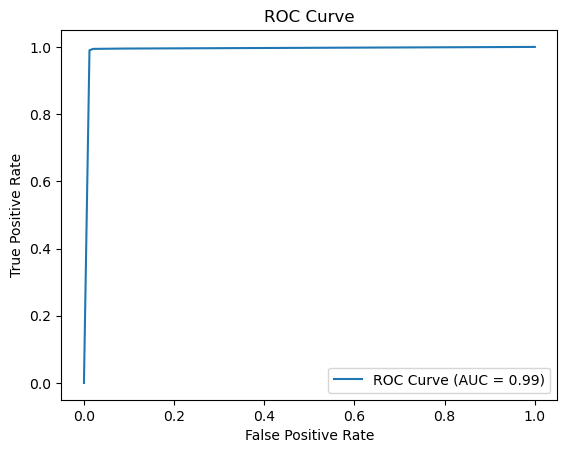

Total Expected Loss: $4,572,152,377.23
Total Net Profit (in millions): $960,021,731.85


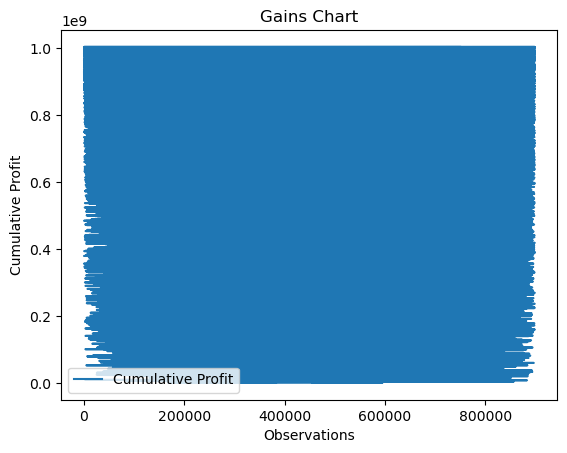

{'specificity': 0.9101149009318737,
 'precision': 0.9804111007048849,
 'recall': 0.9951567065604611,
 'f1_score': 0.9877288731520061,
 'accuracy': 0.9797522083285534,
 'auc': 0.9911701956335102,
 'total_net_profit': 960021731.85,
 'total_expected_loss': 4572152377.225768}

In [19]:
evaluate_model(knn, X_test, y_test)

Classification Metrics:
Specificity: 0.99
Precision: 1.00
Recall: 0.99
F1-Score: 1.00
Accuracy: 0.99
AUC: 0.99

Confusion Matrix:
[[21912   194]
 [  605 99327]]

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98     22106
        True       1.00      0.99      1.00     99932

    accuracy                           0.99    122038
   macro avg       0.99      0.99      0.99    122038
weighted avg       0.99      0.99      0.99    122038



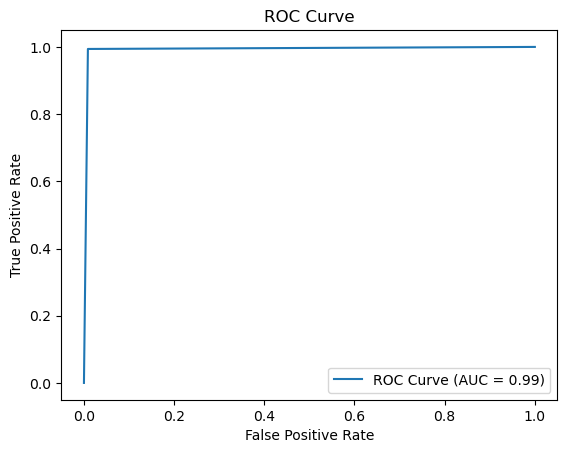

Total Expected Loss: $4,554,224,844.57
Total Net Profit (in millions): $994,743,806.70


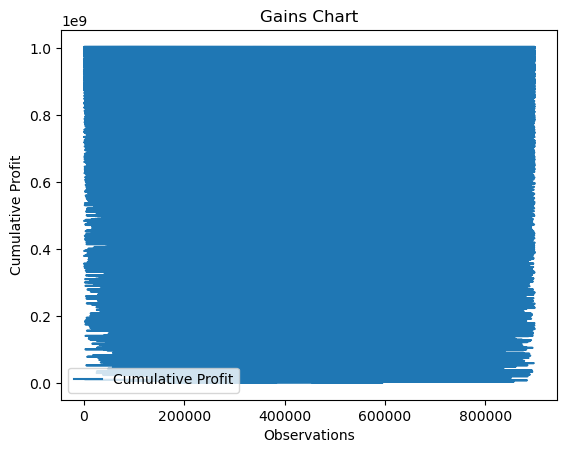

{'specificity': 0.9912241020537411,
 'precision': 0.9980506626742095,
 'recall': 0.9939458832005764,
 'f1_score': 0.9959940437095456,
 'accuracy': 0.9934528589455743,
 'auc': 0.9925849926271587,
 'total_net_profit': 994743806.6999999,
 'total_expected_loss': 4554224844.572238}

In [20]:
evaluate_model(bst, X_test, y_test)

In [21]:
#Loan-to-Approval Ratio
#a ratio between DisbursementGross and GrAppv 
df["Loan_to_Approval_Ratio"] = df["DisbursementGross"] / df["GrAppv"]
df["Loan_to_Approval_Ratio"].head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: Loan_to_Approval_Ratio, dtype: float64

In [22]:
#Credit Line Usage 
# Convert `RevLineCr_Y` into a binary indicator
df['Revolving_Credit_Indicator'] = df['RevLineCr_Y'].apply(lambda x: 1 if x == 'Y' else 0)

# Display the result
df['Revolving_Credit_Indicator'].head()

0    0
1    0
2    0
3    0
4    0
Name: Revolving_Credit_Indicator, dtype: int64

In [23]:
#Loan Age
# Ensure ApprovalDate_year is in datetime format
df['ApprovalDate_year'] = pd.to_datetime(df['ApprovalDate_year'].astype(str) + '-01-01', errors='coerce')

# Current date
current_date = pd.Timestamp('2024-11-25')

# Calculate Loan Age in years
df['Loan_Age'] = (current_date - df['ApprovalDate_year']).dt.days / 365

# Display the first few rows of Loan_Age
print(df['Loan_Age'].head())

0    27.917808
1    27.917808
2    27.917808
3    27.917808
4    27.917808
Name: Loan_Age, dtype: float64


In [24]:
#Employment-to-Loan Size Ratio 
# Calculate Employment-to-Loan Size Ratio
df['Employment_to_Loan_Ratio'] = df['NoEmp'] / df['DisbursementGross']
df['Employment_to_Loan_Ratio'].head()

0    0.000067
1    0.000050
2    0.000024
3    0.000057
4    0.000061
Name: Employment_to_Loan_Ratio, dtype: float64

In [25]:
df['CreateJob_to_NoEmp'] = df['CreateJob'] / df['NoEmp']
df['CreateJob_to_NoEmp'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.5
Name: CreateJob_to_NoEmp, dtype: float64

In [26]:
df['RetainedJob_to_NoEmp'] = df['RetainedJob'] / df['NoEmp']
df['RetainedJob_to_NoEmp'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.5
Name: RetainedJob_to_NoEmp, dtype: float64

In [27]:
df['CreateJob_to_DisbursementGross'] = df['CreateJob'] / df['DisbursementGross']
df['CreateJob_to_DisbursementGross'].head()

0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    0.000031
Name: CreateJob_to_DisbursementGross, dtype: float64